In [1]:
%load_ext autoreload
%autoreload 2

In [22]:
import os
import jax
import timecast as tc
from timecast.utils.experiment import experiment
import pandas as pd
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model, Model
from tqdm.notebook import tqdm
import binpacking
import pickle

In [23]:
test_keys = np.load('data/fusion/FRNN_1d_sample/test_list.npy')
MSE = lambda true, pred: jnp.square(jnp.asarray(true) - jnp.asarray(pred)).mean()

# PredictLast

In [24]:
@experiment("shot", test_keys)
def runner(shot):
    import jax
    import pickle
    import jax.numpy as jnp
    
    from timecast.modules import PredictLast
    
    MSE = lambda true, pred: jnp.square(jnp.asarray(true) - jnp.asarray(pred)).mean()
    
    pl = PredictLast()
    
    data = pickle.load(open(f"data/fusion/original/{shot}.pkl", "rb"))
    
    # Locked mode amplitude
    xs = data[:, 3]
    xs, ts, s = xs[:-30], xs[1:-29], xs[30:]
    
    
    def loop(module, xy):
        x, y = xy
        return module, module(x)
    
    ar, ys = jax.lax.scan(loop, pl, (xs, ts))
    
    return {
        "shot": shot,
        "mse": MSE(s.squeeze(), ys.squeeze())
    }

In [25]:
pl_results = runner.run(processes=50, tqdm=tqdm)

In [26]:
np.mean([shot["mse"] for shot in pl_results])

0.6680888

In [27]:
pl_results = {shot["shot"]: shot["mse"] for shot in pl_results}

# AR

In [8]:
@experiment("shot", test_keys)
@experiment("history_len", [200])
@experiment("learning_rate", [1e-5])
def runner(shot, history_len, learning_rate):
    import jax
    import pickle
    import jax.numpy as jnp
    
    from timecast.modules import AR
    from timecast.optim import SGD, NormThreshold
    
    MSE = lambda true, pred: jnp.square(jnp.asarray(true) - jnp.asarray(pred)).mean()
    
    ar = AR(history_len, 1, 1)
    
    data = pickle.load(open(f"data/fusion/original/{shot}.pkl", "rb"))
    
    # Locked mode amplitude
    xs, ts, s = data[:-30, 3], data[1:-29, 3], data[30:, 3]
    
    sgd = SGD(learning_rate=learning_rate)
    nl_k = NormThreshold(0.03, filter=lambda x: "kernel" in x)
    nl_b = NormThreshold(1e-4, filter=lambda x: "bias" in x)
    def loop(module, xy):
        x, y = xy
        pred = module(x)
        module = sgd(module, x, y)
        module = nl_k(module)
        module = nl_b(module)

        return module, pred

    ar, ys = jax.lax.scan(loop, ar, (xs, ts))
    
    return {
        "shot": shot,
        "history_len": history_len,
        "learning_rate": learning_rate,
        "mse": MSE(s.squeeze(), ys.squeeze()),
    }

In [9]:
ar_results = runner.run(processes=50, tqdm=tqdm)

In [10]:
ar_df = pd.DataFrame.from_dict(ar_results)
ar_df = ar_df.astype(float)
ar_df.pivot_table(values="mse", index=["history_len"], columns=["learning_rate"])

learning_rate,0.00001
history_len,
200.0,13.469981


In [11]:
ar_results = {shot["shot"]: shot["mse"] for shot in ar_results}

In [12]:
less = [shot for shot in ar_results if ar_results[shot] < pl_results[shot]]

In [13]:
less

[158891]

In [14]:
less[0]

158891

# AR on PL resid

In [15]:
@experiment("shot", test_keys)
@experiment("history_len", [5, 10, 20])
@experiment("learning_rate", [1e-7])
@experiment("thresh", [0.1])
def runner(shot, history_len, learning_rate, thresh):
    import jax
    import pickle
    import jax.numpy as jnp
    
    from timecast.modules import AR
    from timecast.optim import SGD, NormThreshold
    
    MSE = lambda true, pred: jnp.square(jnp.asarray(true) - jnp.asarray(pred)).mean()
    
    ar = AR(history_len, 1, 1)
    
    data = pickle.load(open(f"data/fusion/original/{shot}.pkl", "rb"))
    
    # Locked mode amplitude
    xs, ts, s = data[:-30, 3], data[1:-29, 3] - data[:-30, 3], data[30:, 3]
    
    sgd = SGD(learning_rate=learning_rate)
    nl_k = NormThreshold(thresh, filter=lambda x: "kernel" in x)
    nl_b = NormThreshold(1e-4, filter=lambda x: "bias" in x)
    def loop(module, xy):
        x, y = xy
        pred = module(x)
        module = sgd(module, x, y)
        module = nl_k(module)
        module = nl_b(module)

        return module, pred

    ar, ys = jax.lax.scan(loop, ar, (xs, ts))
    ys = ys.squeeze()
    ys += data[:-30, 3].squeeze()
    
#     pickle.dump({
#         "shot": shot,
#         "history_len": history_len,
#         "learning_rate": learning_rate,
#         "mse": MSE(s.squeeze(), ys.squeeze()),
#         "pl_mse": MSE(s.squeeze(), xs.squeeze()),
#         "xs": xs.squeeze(),
#         "ts": ts.squeeze(),
#         "ys": ys.squeeze(),
#         "s": s.squeeze()
#     }, open(f"data/fusion/ar/{shot}.pkl", "wb"))
    
    return {
        "shot": shot,
        "history_len": history_len,
        "learning_rate": learning_rate,
        "thresh": thresh,
        "mse": MSE(s.squeeze(), ys.squeeze()),
    }

In [16]:
resid_results = runner.run(processes=50, tqdm=tqdm)

In [17]:
resid_df = pd.DataFrame.from_dict(resid_results)
resid_df = resid_df.astype(float)
resid_df.pivot_table(values="mse", index=["history_len"], columns=["learning_rate", "thresh"])

learning_rate 1.000000e-07                     1.000000e-06            \
thresh                 0.1       0.3       0.5          0.1       0.3   
history_len                                                             
5.0               0.667728  0.667728  0.667728     0.667508  0.667508   
10.0              0.667698  0.667698  0.667698     0.668087  0.668087   
20.0              0.667819  0.667819  0.667819     0.668266  0.668266   

learning_rate           1.000000e-05                         
thresh              0.5          0.1        0.3         0.5  
history_len                                                  
5.0            0.667508     0.669260   0.669260    0.669260  
10.0           0.668087     2.265493  14.942421   40.226048  
20.0           0.668266     4.867954  38.372155  105.307749

In [14]:
resid_df = pd.DataFrame.from_dict(resid_results)
resid_df = resid_df.astype(float)
resid_df.pivot_table(values="mse", index=["history_len"], columns=["learning_rate", "thresh"])

learning_rate 1.000000e-07                     1.000000e-06              \
thresh                 0.1       0.3       0.5          0.1         0.3   
history_len                                                               
50.0              0.668197  0.668197  0.668197     0.670672    0.670672   
100.0             0.668807  0.668807  0.668807    16.139026  139.271070   
200.0             0.669563  0.669563  0.669563    41.373428  366.389364   

learning_rate              1.000000e-05                           
thresh                 0.5          0.1         0.3          0.5  
history_len                                                       
50.0              0.670672    12.885104  110.508258   305.649828  
100.0           384.921156    26.888689  236.416223   654.836401  
200.0          1015.761596    55.146215  490.355464  1359.719041

In [18]:
resid_results = {shot["shot"]: shot["mse"] for shot in resid_results if (shot["history_len"] == 10 and shot["thresh"] == 0.1)}

0.057042837 0.057175115


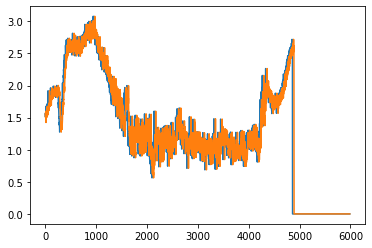

In [38]:
shot = 156680
data = pickle.load(open(f"data/fusion/ar/{shot}.pkl", "rb"))
plt.plot(data["s"])
plt.plot(data["xs"])
# plt.plot(data["ys"])
print(MSE(data["s"], data["xs"]), MSE(data["s"], data["ys"]))

In [39]:
less = [shot for shot in resid_results if resid_results[shot] < pl_results[shot]]
more = [shot for shot in resid_results if resid_results[shot] >= pl_results[shot]]
thresh = [shot for shot in resid_results if (resid_results[shot] - pl_results[shot] > 0.1)]
diff = [resid_results[shot] - pl_results[shot] for shot in resid_results]

In [46]:
diff = np.sort(diff)

In [47]:
diff

array([-3.38664889e-01, -3.35353732e-01, -3.07311893e-01, -2.91505694e-01,
       -2.21143484e-01, -9.91854668e-02, -3.54251862e-02, -3.37429047e-02,
       -2.06124783e-02, -1.45069361e-02, -1.39760971e-02, -1.20018721e-02,
       -1.03838146e-02, -9.68551636e-03, -8.05544853e-03, -6.24036789e-03,
       -6.19566441e-03, -4.76002693e-03, -4.71687317e-03, -4.29934263e-03,
       -4.09483910e-03, -4.02379036e-03, -3.51819396e-03, -3.47262621e-03,
       -2.66265869e-03, -2.50327587e-03, -2.50077248e-03, -2.39276886e-03,
       -2.25311518e-03, -2.08365917e-03, -2.05051899e-03, -1.44383311e-03,
       -1.42228603e-03, -1.26183033e-03, -1.18630379e-03, -1.03223324e-03,
       -9.78469849e-04, -8.97496939e-04, -8.60601664e-04, -8.19683075e-04,
       -8.07270408e-04, -7.86125660e-04, -7.38978386e-04, -7.07417727e-04,
       -5.83767891e-04, -5.71250916e-04, -4.93824482e-04, -4.73678112e-04,
       -4.35426831e-04, -4.33743000e-04, -4.29660082e-04, -3.92913818e-04,
       -3.91244888e-04, -

In [31]:
len(less)

193

In [32]:
len(more)

669

In [35]:
less

[156680,
 157196,
 165470,
 150874,
 165042,
 157381,
 166390,
 163548,
 165034,
 164289,
 167506,
 146656,
 164208,
 157536,
 155151,
 162785,
 160588,
 163552,
 146812,
 154728,
 145128,
 166674,
 146944,
 147359,
 158891,
 165923,
 165040,
 161261,
 165468,
 166411,
 165863,
 159161,
 162997,
 166537,
 158084,
 165351,
 163755,
 164523,
 165438,
 163184,
 146212,
 149027,
 166356,
 156897,
 155169,
 165935,
 155141,
 165940,
 161613,
 162905,
 165177,
 165961,
 164371,
 158089,
 165673,
 156637,
 145052,
 163819,
 165708,
 155148,
 149084,
 146677,
 162791,
 147426,
 163723,
 167462,
 163317,
 147344,
 164835,
 166386,
 149082,
 159376,
 162977,
 147199,
 164356,
 163553,
 144770,
 148801,
 160334,
 161167,
 159379,
 149211,
 153327,
 162780,
 161263,
 145044,
 160005,
 160708,
 161320,
 146625,
 163318,
 160339,
 147207,
 161015,
 160706,
 165933,
 161322,
 156744,
 153402,
 162829,
 164504,
 160137,
 149086,
 141495,
 160503,
 166306,
 165444,
 145043,
 154723,
 157198,
 158617,
 